In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR


from sklearn.model_selection import train_test_split

In [2]:
WINDOW_SIZE = 256
SLIDE_FACTOR = 0.3
BATCH_SIZE = 64

VALID_SIZE = 0.2
TEST_SIZE = 0.2

N_EPOCHS=100

Load the dataset

In [3]:
file_path = 'dataset/modis/fire_archive_M6_96619.csv'
dataset_f = pd.read_csv(file_path)
dataset_f.drop(['bright_t31', 'daynight', 'confidence', 'frp', 'brightness'], axis=1, inplace=True)
unprocessed = dataset_f.copy()

dataset_f.head()

,latitude,longitude,timestamp
0,-11.8070,142.0583,1564646160
1,-11.7924,142.0850,1564646160
2,-12.8398,132.8744,1564646220
3,-14.4306,143.3035,1564646220
4,-12.4953,131.4897,1564646220


## Prepare the dataset

We need to scale or convert to categorical the entire dataset

### Get some minimum/maximum values

In [4]:
# get some min/max values
bounds = {
    'latitude': {
        "max": dataset_f['latitude'].max(),
        "min": dataset_f['latitude'].min()
    },
    'longitude': {
        "max": dataset_f['longitude'].max(),
        "min": dataset_f['longitude'].min()
    },
    # 'brightness': {
    #     "max": dataset_f['brightness'].max(),
    #     "min": dataset_f['brightness'].min()
    # },
    # 'confidence': {
    #     "max": dataset_f['confidence'].max(),
    #     "min": dataset_f['confidence'].min()
    # },
    'timestamp': {
        "max": dataset_f['timestamp'].max(),
        "min": dataset_f['timestamp'].min()
    }
    # 'frp': {
    #     'max': dataset_f['frp'].max(),
    #     'min': dataset_f['frp'].min()
    # }
}

print(bounds)

{'latitude': {'max': -10.0726, 'min': -42.7628}, 'longitude': {'max': 153.4904, 'min': 114.1043}, 'timestamp': {'max': 1569887100, 'min': 1564646160}}


### Scale every column

In [5]:
# create a function to scale values into [0, 1]
def scale(x, min, max):
    return (x-min) / (max-min)

def unscale(x, min, max):
    rng = max - min
    return (x*rng) + min

### Map daynight data to categorical

In [6]:
def create_map(df, col):
    unique_set = set(df[col].unique())
    return {key: i for i,key in enumerate(unique_set)}

def preprocess(df):
    res = df.copy()
    # # create the daynight mapping
    # daynight_map = create_map(res, "daynight")
    # inv_daynight_map = {i: key for key, i in daynight_map.items()}
    # # apply the mapping
    # res['daynight'] = res['daynight'].map(daynight_map).fillna(res['daynight'])
    # res.head(10)

    # scale every column in the dataset
    for col in res.columns:
        b = bounds.get(col)
        if b is not None:
            res[col] = res[col].apply(scale, args=(b['min'], b['max']))

    return res

dataset_f = preprocess(dataset_f)
dataset_f.head()

,latitude,longitude,timestamp
0,0.946944,0.709743,0.000000
1,0.947391,0.710421,0.000000
2,0.915351,0.476567,0.000011
3,0.866688,0.741358,0.000011
4,0.925889,0.441410,0.000011


## Undo preprocessing

In [7]:
def unprocess(df):
    res = df.copy()
    for col in res.columns:
        b = bounds.get(col)
        if b is not None:
            res[col] = res[col].apply(unscale, args=(b['min'], b['max']))

    # turn the day/night column back into letters
    # res['daynight'] = res['daynight'].map(inv_daynight_map).fillna(res['daynight'])

    return res

unprocess(dataset_f).head()

,latitude,longitude,timestamp
0,-11.8070,142.0583,1.564646e+09
1,-11.7924,142.0850,1.564646e+09
2,-12.8398,132.8744,1.564646e+09
3,-14.4306,143.3035,1.564646e+09
4,-12.4953,131.4897,1.564646e+09


## Split into sequences of inputs and labels

In [8]:
# split into inputs and labels
def xy_split(df):
    dset_x = []
    dset_y = []
    for i in range(df.shape[0]-1):
        dset_x.append(df.loc[i])
        dset_y.append(df.loc[i+1])

    dset_x = np.array(dset_x)
    dset_y = np.array(dset_y)

    return dset_x, dset_y

dset_x, dset_y = xy_split(dataset_f)

# arrange into sequences
# we need to do this because we cannot randomly pick readings from the dataset and still have valid inputs
# | their relative location is *very* important
def sequencify(xs, ys):
    sequence_x = []
    sequence_y = []
    for i in range(0, xs.shape[0]-WINDOW_SIZE, int(WINDOW_SIZE*SLIDE_FACTOR)):
        sequence_x.append(xs[i:i+WINDOW_SIZE])
        sequence_y.append(ys[i:i+WINDOW_SIZE])

    sequence_x = np.array(sequence_x)
    sequence_y = np.array(sequence_y)

    print(f'{sequence_x.shape=}, {sequence_y.shape=}')
    return np.concatenate([sequence_x[:,:,:], sequence_y[:,:,:]], axis=2)

sequences = sequencify(dset_x, dset_y)

sequence_x.shape=(471, 256, 3), sequence_y.shape=(471, 256, 3)


## Split into training, validation, and testing

In [9]:
train, t2 = train_test_split(sequences, shuffle=False, test_size=(TEST_SIZE+VALID_SIZE))
valid, test = train_test_split(t2, shuffle=False, test_size =TEST_SIZE / (TEST_SIZE+VALID_SIZE))

print(f'{train.shape=}, {valid.shape=}, {test.shape=}')

train.shape=(282, 256, 6), valid.shape=(94, 256, 6), test.shape=(95, 256, 6)


# Create the model

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

event_vec_dim = dataset_f.shape[-1]
seq_len = WINDOW_SIZE
hidden_dim = 1024
num_layers = 4

In [11]:
class FirePredictor(nn.Module):
    def __init__(self,  event_vec_dim, seq_len, hidden_dim, num_layers):
        super(FirePredictor, self).__init__()
        self.event_vec_dim = event_vec_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.seq_len = seq_len

        self.lstm = nn.LSTM(
            self.event_vec_dim,
            self.hidden_dim,
            num_layers = self.num_layers,
            dropout=0.2,
            batch_first=True,
            device=device
        )
        self.flatten = nn.Flatten()
        self.output = nn.Linear(hidden_dim*seq_len, event_vec_dim*seq_len, device=device)

    def forward(self, x):
        h1 = self.lstm(x)[0]
        flat = self.flatten(h1)
        return self.output(flat).reshape(x.shape[0], self.seq_len, self.event_vec_dim)

# create the model
model = FirePredictor(event_vec_dim, seq_len, hidden_dim, num_layers)

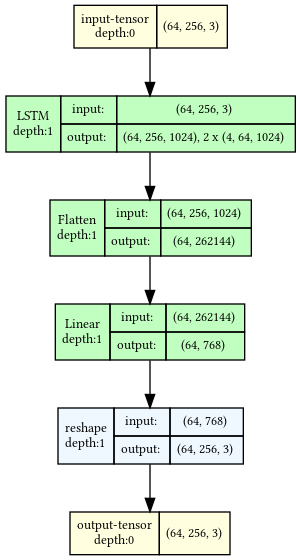

In [12]:
# visualize model structure
# This uses torchview, which is a library outside of pytorch for visualizing torch.nn.Modules
# https://github.com/mert-kurttutan/torchview
import graphviz
graphviz.set_jupyter_format('png')

from torchview import draw_graph
model_graph = draw_graph(model, input_size=(BATCH_SIZE, WINDOW_SIZE, event_vec_dim), device='cuda')
model_graph.visual_graph

## Write the loss function

In [24]:
# def euclidean_dist(t1, t2, dim):
#     return (t1 - t2).pow(2).sum(dim).sqrt()
#
# def avg_distance(x, y):
#     if x.isnan().any():
#         print(x)
#         raise RuntimeError("Loss func: x contains NAN")
#     # use nearest neighbor upsampling
#     reshaped = torch.nn.functional.interpolate(x[:,:,None,:], size=y.shape[2:], mode='nearest')
#     if reshaped.isnan().any():
#         print(reshaped)
#         raise RuntimeError("Loss func: reshaped x contains NAN")
#     result = (euclidean_dist(reshaped, y, dim=2)).sum() / np.array(y.shape[0:-1]).prod()
#     if result.isnan().any():
#         print(result)
#         raise RuntimeError("Loss func: result contains NAN")
#     return result
#
#
# x = torch.Tensor(sequences[0:3,0:64,0,:])
# y = torch.Tensor(sequences[0:3,0:64,1:,:])
#
# print(avg_distance(torch.Tensor(x), torch.Tensor(y)))
# print(f'{x.shape=}, {y.shape=}')

IndexError: too many indices for array: array is 3-dimensional, but 4 were indexed

## Prepare Optimizer, Scheduler, and Data Loader

In [14]:
# split train & validation data into inputs and labels
x_train = torch.Tensor(train[:,:,0:3])
y_train = torch.Tensor(train[:,:,3:])

x_valid = torch.Tensor(valid[:,:,0:3]).to(device)
y_valid = torch.Tensor(valid[:,:,3:]).to(device)

In [15]:
print(f'{x_valid.shape=}, {y_valid.shape}')

x_valid.shape=torch.Size([94, 256, 3]), torch.Size([94, 256, 3])


In [16]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9)

scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

data_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=BATCH_SIZE)

loss_function = nn.MSELoss()

## Training Loop

In [17]:
losses_train = np.zeros(N_EPOCHS)
losses_valid = np.zeros(N_EPOCHS)

for epoch in range(N_EPOCHS):
    # loop over batches
    acc_train_loss = 0.0
    for i, data in enumerate(data_loader):

        x_batch, y_batch = data
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()

        preds = model(x_batch)

        loss = loss_function(preds, y_batch)
        acc_train_loss += loss
        loss.backward()

        optimizer.step()

    # record average loss of all batches in this epoch
    losses_train[epoch] = acc_train_loss / (x_train.shape[0]/BATCH_SIZE)
    
    # compute validation loss
    model.eval()
    with torch.no_grad():
        v_preds = model(x_valid)
        losses_valid[epoch] = loss_function(v_preds, y_valid).item()
    model.train()

    # print out the losses so we can see it update as we train
    print(f'Epoch {epoch} -- train loss: {losses_train[epoch]} valid loss: {losses_valid[epoch]}')

Epoch 0 -- train loss: 0.43548399209976196 valid loss: 0.43791717290878296
Epoch 1 -- train loss: 0.32535335421562195 valid loss: 0.2728712260723114
Epoch 2 -- train loss: 0.1280413717031479 valid loss: 0.07615692913532257
Epoch 3 -- train loss: 0.07822053879499435 valid loss: 0.10342428833246231
Epoch 4 -- train loss: 0.09353198111057281 valid loss: 0.07693398743867874
Epoch 5 -- train loss: 0.07093209773302078 valid loss: 0.10845646262168884
Epoch 6 -- train loss: 0.06846114993095398 valid loss: 0.0820477306842804
Epoch 7 -- train loss: 0.051958706229925156 valid loss: 0.06742244213819504
Epoch 8 -- train loss: 0.05972420424222946 valid loss: 0.06831394881010056
Epoch 9 -- train loss: 0.05854569375514984 valid loss: 0.07514264434576035
Epoch 10 -- train loss: 0.05681995302438736 valid loss: 0.07913405448198318
Epoch 11 -- train loss: 0.0546911396086216 valid loss: 0.07404481619596481
Epoch 12 -- train loss: 0.05371897667646408 valid loss: 0.0707678273320198
Epoch 13 -- train loss: 0.

In [18]:
model(x_train[0][None, :, :].to(device))

tensor([[[0.7136, 0.6402, 0.3579],
         [0.7087, 0.6525, 0.3580],
         [0.7166, 0.6451, 0.3581],
         [0.7163, 0.6462, 0.3582],
         [0.7139, 0.6449, 0.3580],
         [0.7160, 0.6461, 0.3581],
         [0.7157, 0.6572, 0.3581],
         [0.7110, 0.6503, 0.3582],
         [0.7140, 0.6497, 0.3582],
         [0.7130, 0.6594, 0.3583],
         [0.7131, 0.6571, 0.3584],
         [0.7089, 0.6607, 0.3583],
         [0.7064, 0.6656, 0.3586],
         [0.7097, 0.6603, 0.3585],
         [0.7038, 0.6589, 0.3585],
         [0.7055, 0.6651, 0.3585],
         [0.7016, 0.6684, 0.3585],
         [0.7036, 0.6681, 0.3587],
         [0.7104, 0.6645, 0.3586],
         [0.7075, 0.6579, 0.3587],
         [0.7027, 0.6575, 0.3588],
         [0.7058, 0.6489, 0.3587],
         [0.6983, 0.6563, 0.3587],
         [0.7030, 0.6578, 0.3587],
         [0.7005, 0.6641, 0.3588],
         [0.7027, 0.6590, 0.3589],
         [0.7057, 0.6557, 0.3590],
         [0.7063, 0.6630, 0.3590],
         [0.7048, 0.

## Visualize results

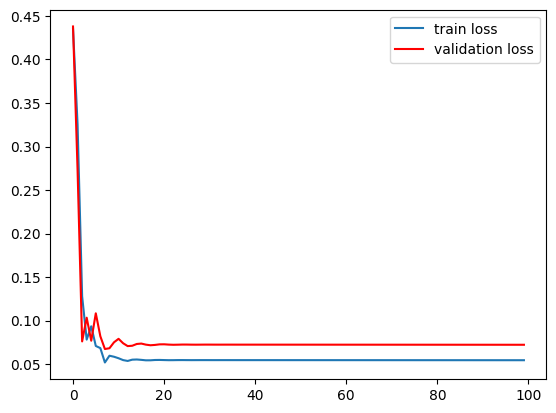

In [19]:
import matplotlib.pyplot as plt
plt.plot(losses_train, label='train loss')
plt.plot(losses_valid, label='validation loss', color='r')
plt.legend()

plt.show()

In [20]:
model.eval()
with torch.no_grad():
    res = pd.DataFrame(model(x_train[0][None,:,:].to(device)).cpu().detach()[0], columns=dataset_f.columns)

prediction = unprocess(res)
actual = unprocess(pd.DataFrame(y_train[0], columns=dataset_f.columns))

display(prediction)
display(actual)

,latitude,longitude,timestamp
0,-19.435477,139.319946,1.566522e+09
1,-19.595768,139.803473,1.566522e+09
2,-19.338563,139.510517,1.566523e+09
3,-19.347511,139.556675,1.566523e+09
4,-19.425489,139.504937,1.566522e+09
...,...,...,...
251,-19.691062,139.919792,1.566559e+09
252,-19.758829,140.313131,1.566560e+09
253,-19.594581,140.006536,1.566559e+09
254,-19.502197,139.992077,1.566559e+09


,latitude,longitude,timestamp
0,-11.792400,142.084999,1.564646e+09
1,-12.839799,132.874400,1.564646e+09
2,-14.430599,143.303500,1.564646e+09
3,-12.495301,131.489700,1.564646e+09
4,-12.619100,142.199799,1.564646e+09
...,...,...,...
251,-15.092801,131.061700,1.564662e+09
252,-15.235401,130.230999,1.564662e+09
253,-14.946200,131.819100,1.564662e+09
254,-14.932999,131.816700,1.564662e+09


In [23]:
actual.mean()

latitude    -1.881042e+01
longitude    1.349499e+02
timestamp    1.564655e+09
dtype: float64